In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
img = cv2.imread('/content/drive/MyDrive/test_images/ariel_tatum.jpeg')
print(img.shape)

(1600, 1112, 3)


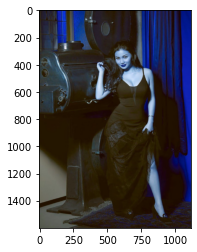

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)

(1600, 1112)


In [ ]:
print(gray)

[[46 32 27 ... 49 49 49]
 [44 31 27 ... 49 49 49]
 [40 28 26 ... 49 49 49]
 ...
 [78 83 81 ... 33 35 36]
 [78 82 81 ... 28 30 32]
 [78 82 81 ... 25 25 26]]


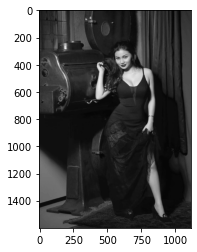

In [ ]:
plt.imshow(gray, cmap = 'gray')
plt.show()

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haar cascade/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haar cascade/haarcascade_haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3,5)
print(faces)

[[531 291 152 152]]


In [ ]:
(x,y,w,h) = faces[0]
x,y,w,h

(531, 291, 152, 152)

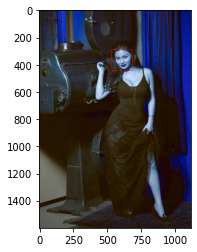

In [ ]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

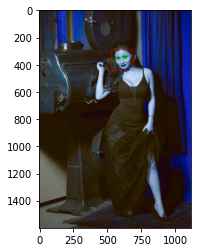

In [ ]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
  face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  roi_gray = gray[y:y+h, x:x+w]
  roi_color = face_img[y:y+h, x:x+w]
  eyes = eye_cascade.detectMultiScale(roi_gray)
  for (ex,ey,ew,eh) in eyes:
    cv2.rectangle(roi_color, (ex,ey), (ex+ew, ey+eh), (0,255,0), 2)

plt.figure()
plt.imshow(face_img, cmap = 'gray')
plt.show()

## Preprocessing: Crop the facial region of the image

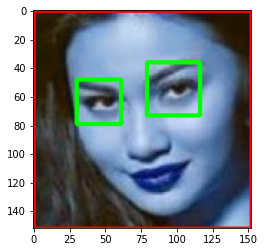

In [ ]:
%matplotlib inline
plt.imshow(roi_color, cmap = 'gray')
plt.show()

In [ ]:
cropped_img = np.array(roi_color)
print(cropped_img.shape)

(152, 152, 3)


## Preprocessing: Use wavelet transform as a feature for training our model

In wavelet transformed image, you can see edges and that can give us clues on various features such as eyes, nose, lips etc.

### Wavelet Transform

In [ ]:
import numpy as np
import pywt
import cv2

def w2d(img, mode = 'haar', level = 1):
  imArray = img

  # Datatype conversions
  # Convert to grayscale
  imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)

  # Convert to float
  imArray = np.float32(imArray)
  imArray = imArray / 255;

  # Compute coefficients
  coeffs = pywt.wavedec2(imArray, mode, level = level)

  # Process coefficients
  coeffs_H = list(coeffs)
  coeffs_H[0] *= 0;

  # Reconstruction
  imArray_H = pywt.waverec2(coeffs_H, mode);
  imArray_H *= 255;
  imArray_H = np.uint8(imArray_H)

  return imArray_H

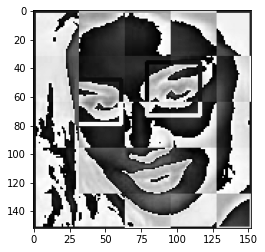

In [ ]:
im_har = w2d(cropped_img, 'db1', 5)
plt.imshow(im_har, cmap = 'gray')
plt.show()

You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

## Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region.

Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [ ]:
def get_cropped_image_if_2_eyes(image_path):
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    if len(eyes) >= 2:
      return roi_color

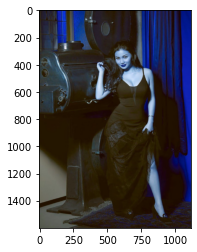

In [ ]:
original_image = cv2.imread('/content/drive/MyDrive/test_images/ariel_tatum.jpeg')
plt.imshow(original_image)

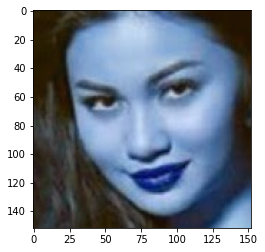

In [ ]:
cropped_image = get_cropped_image_if_2_eyes('/content/drive/MyDrive/test_images/ariel_tatum.jpeg')
plt.imshow(cropped_image)

In [ ]:
path_to_data = '/content/drive/MyDrive/dataset_images/'
path_to_cropped_data = '/content/drive/MyDrive/dataset_images/cropped_img/'

In [ ]:
import os 
img_dirs = []
for entry in os.scandir(path_to_data):
  if entry.is_dir():
    img_dirs.append(entry.path)

In [ ]:
img_dirs

['/content/drive/MyDrive/dataset_images/raisa_andriana',
 '/content/drive/MyDrive/dataset_images/pevita_pearce',
 '/content/drive/MyDrive/dataset_images/maudy_ayunda',
 '/content/drive/MyDrive/dataset_images/isyana_sarasvati',
 '/content/drive/MyDrive/dataset_images/ariel_tatum',
 '/content/drive/MyDrive/dataset_images/.ipynb_checkpoints',
 '/content/drive/MyDrive/dataset_images/cropped_img']

Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside datsaet folder after you run this code

In [ ]:
import shutil

if os.path.exists(path_to_cropped_data):
  shutil.rmtree(path_to_cropped_data)
os.mkdir(path_to_cropped_data)

In [ ]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
  count = 1
  celebrity_name = img_dir.split('/')[-1]
  celebrity_file_names_dict[celebrity_name] = []
  for entry in os.scandir(img_dir):
    roi_color = get_cropped_image_if_2_eyes(entry.path)
    if roi_color is not None:
      cropped_folder = path_to_cropped_data + celebrity_name
      if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder)
        cropped_image_dirs.append(cropped_folder)
        print('Generating cropped images in folder: ', cropped_folder)
      cropped_file_name = celebrity_name + str(count) + ".png"
      cropped_file_path = cropped_folder + "/" + cropped_file_name
      cv2.imwrite(cropped_file_path, roi_color)
      celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
      count += 1

Generating cropped images in folder:  /content/drive/MyDrive/dataset_images/cropped_img/raisa_andriana
Generating cropped images in folder:  /content/drive/MyDrive/dataset_images/cropped_img/pevita_pearce
Generating cropped images in folder:  /content/drive/MyDrive/dataset_images/cropped_img/maudy_ayunda
Generating cropped images in folder:  /content/drive/MyDrive/dataset_images/cropped_img/isyana_sarasvati
Generating cropped images in folder:  /content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum


error: ignored

In [ ]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
  celebrity_name = img_dir.split('/')[-1]
  file_list = []
  for entry in os.scandir(img_dir):
    file_list.append(entry.path)
  celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'ariel_tatum': ['/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum1.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum2.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum3.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum4.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum5.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum6.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum7.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum8.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum9.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum10.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_tatum/ariel_tatum11.png',
  '/content/drive/MyDrive/dataset_images/cropped_img/ariel_

In [ ]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
  class_dict[celebrity_name] = count
  count = count + 1
class_dict

{'ariel_tatum': 4,
 'isyana_sarasvati': 3,
 'maudy_ayunda': 2,
 'pevita_pearce': 1,
 'raisa_andriana': 0}

Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [ ]:
X, y = [],[]
for celebrity_name, training_files in celebrity_file_names_dict.items():
  for training_image in training_files:
    img = cv2.imread(training_image)
    scalled_raw_img = cv2.resize(img, (32,32))
    img_har = w2d(img, 'db1', 5)
    scalled_img_har = cv2.resize(img_har, (32,32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32,1)))
    X.append(combined_img)
    y.append(class_dict[celebrity_name])

In [ ]:
len(X[0])

4096

In [ ]:
32*32*3 + 32*32

4096

In [ ]:
X[0]

array([[ 56],
       [ 52],
       [ 63],
       ...,
       [ 49],
       [174],
       [251]], dtype=uint8)

In [ ]:
y[0]

0

In [ ]:
X = np.array(X).reshape(len(X), 4096).astype(float)
print(X.shape)

(283, 4096)


### Data cleaning process is done. Now we are ready to train our model

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.metrics import classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size = 0.1)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C = 1))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7586206896551724

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.617961,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.445098,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.598431,{'logisticregression__C': 1}


In [ ]:
best_estimators['svm'].score(X_test, y_test)

0.7586206896551724

In [ ]:
best_clf = best_estimators['svm']

Text(69.0, 0.5, 'Truth')

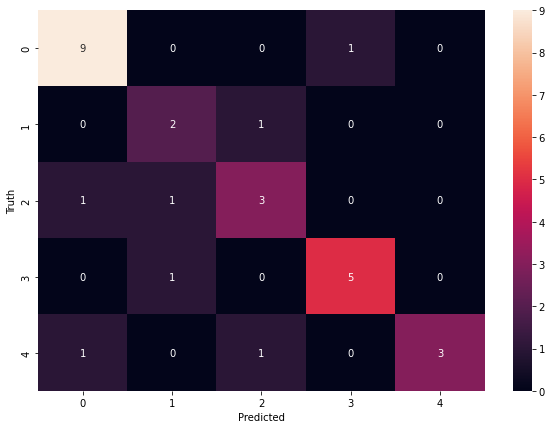

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, best_clf.predict(X_test))
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
class_dict

{'ariel_tatum': 4,
 'isyana_sarasvati': 3,
 'maudy_ayunda': 2,
 'pevita_pearce': 1,
 'raisa_andriana': 0}

### Saved the trained model

In [ ]:
import joblib

joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

### Saved class dictionary

In [ ]:
import json
with open('class_dictionary.json','w') as f:
  f.write(json.dumps(class_dict))